In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from torch.autograd import Variable
import pandas as pd


In [4]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=False)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

print("train_dataset size:", len(train_dataset),"\ntest_dataset size:", len(test_dataset))

train_dataset size: 60000 
test_dataset size: 10000


In [5]:
# Data loader func
def train_loader(batch_size):
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size = batch_size, 
                                           shuffle=True)
    return train_loader


def test_loader(batch_size):
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)
    return test_loader

In [6]:
class Model(nn.Module):
  def __init__(self,):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(784, 500)
        self.fc2 = nn.Linear(500, 10)
        
  def forward(self, x):
        # flatten as one dimension
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
#train function
def trainFunc(model,num_epochs,train_batch_size):
    model.train()
    print('strated')
    train_load = train_loader(train_batch_size)
    n_total_steps = len(train_load)
    train_losses = []
    train_epoch = []
    train_acc = []
    not_converged =True
    epoch = 0
    sensitivity=[]
    while not_converged:
        epoch += 1
        n_correct = 0
        n_samples = 0
        lossSum =0
        for i, (images, labels) in enumerate(train_load):  
            #if (i+1)% 60 == 0 : print(i+1)
            images, labels = Variable(images),Variable(labels)
            
            optimizer.zero_grad()
            
            # Forward pass
            prediction = model(images)

            images.requires_grad = True

            loss = loss_func(prediction, labels)
            lossSum += loss

            # Backward and optimize
            loss.backward()
            optimizer.step()

            #Calculation for sensitivity
            froGrad=0
            count =0 
            
        
            for p in model.parameters():
                grad = 0.0
                if p.grad is not None:
                    grad = p.grad
                    froGrad_norm = torch.linalg.norm(grad).numpy()
                    froGrad += froGrad_norm
                    count += 1
            
            sensitivity.append(froGrad/count)

            
            #loss.backward()
            
            #optimizer.step()

            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            acc = 100.0 * n_correct / n_samples

            train_losses.append(loss.item())
            train_acc.append(acc)
            train_epoch.append(epoch)
        

            if (i+1) % 10 == 0:
                print (f'Train O/P: Epoch [{epoch}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}',end= '\r',flush = True)
                if epoch == num_epochs:
                        print("Max Epoch Reached")
                        not_converged = False
                elif (epoch > 5) and  (train_losses[-1] < 0.001):
                    if abs(train_losses[-3] - train_losses[-2]) < 1.0e-05 and abs(train_losses[-2] - train_losses[-1]) < 1.0e-05:
                        print("Convergeance reached for loss:",train_losses[-1])
                        not_converged = False
                        
        trainAvgLoss = lossSum/i+1
        print("Train Avg loss:",trainAvgLoss)
                        
    return train_epoch,train_losses,train_acc,sensitivity,trainAvgLoss

In [8]:
import copy

In [9]:
batchArr = np.linspace (10,1510,5)
print(batchArr)

[  10.  385.  760. 1135. 1510.]


In [10]:
def testFunction(model,loss_func,test_batch_size): 
    test_load = test_loader(test_batch_size)
    model.eval()
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        testLoss = 0
        count = 0
        for images, labels in test_load:
            images, labels = Variable(images),Variable(labels)
            
            prediction = model(images)
            testLoss += loss_func(prediction,labels).item()
            # max returns (value ,index)
            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            count += 1
    netTest_loss = testLoss/count
    netTest_acc1 = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the test images: {netTest_acc1}% & Test Loss: {netTest_loss} ',end= '\r',flush = True)
    return netTest_acc1, netTest_loss

In [11]:
modelsTrainEpochArr = []
modelsTrainLossArr = []
modelsTrainAccArr = []
modelsTestLossArr = []
modelsTestAccArr = []
modelsSensitivityArr = []

temModel = Model ()

a=[]
for k in temModel.parameters():
    a.append(torch.numel(k))

print(f'Total no of parameters in Model :{np.sum(a)}')

for i in range (len(batchArr)):
    torch.manual_seed(1)
    
    j=copy.deepcopy(i) 
    j = Model()
    loss_func = nn.CrossEntropyLoss()
    
    optimizer = torch.optim.Adam(j.parameters(), lr=1e-3, weight_decay= 1e-4)


    max_epochs = 5
    train_batch_size = int(batchArr[i])

    train_epoch,train_losses,train_acc,sensitivity,tvgLoss = trainFunc(j,max_epochs,train_batch_size)

    test_batch_size = int(batchArr[i])

    testAcc, testLoss = testFunction(j,loss_func,test_batch_size)

    
    
    modelsTrainEpochArr.append(train_epoch)
    modelsTrainLossArr.append(train_losses)
    modelsTrainAccArr.append(train_acc)
    modelsTestAccArr.append(testAcc)
    modelsTestLossArr.append(testLoss)
    modelsSensitivityArr.append(sensitivity)

Total no of parameters in Model :397510
strated
Train Avg loss: tensor(1.1960, grad_fn=<AddBackward0>)
Train Avg loss: tensor(1.0906, grad_fn=<AddBackward0>)
Train Avg loss: tensor(1.0717, grad_fn=<AddBackward0>)
Train Avg loss:  [4/5], Step [6000/6000], Loss: 0.3995tensor(1.0615, grad_fn=<AddBackward0>)
Max Epoch Reached[5/5], Step [10/6000], Loss: 0.1644
Max Epoch Reached[5/5], Step [20/6000], Loss: 0.0027
Max Epoch Reached[5/5], Step [30/6000], Loss: 0.0032
Max Epoch Reached[5/5], Step [40/6000], Loss: 0.0013
Max Epoch Reached[5/5], Step [50/6000], Loss: 0.0087
Max Epoch Reached[5/5], Step [60/6000], Loss: 0.0087
Max Epoch Reached[5/5], Step [70/6000], Loss: 0.0083
Max Epoch Reached[5/5], Step [80/6000], Loss: 0.0042
Max Epoch Reached[5/5], Step [90/6000], Loss: 0.0708
Max Epoch Reached[5/5], Step [100/6000], Loss: 0.0557
Max Epoch Reached[5/5], Step [110/6000], Loss: 0.0190
Max Epoch Reached[5/5], Step [120/6000], Loss: 0.0073
Max Epoch Reached[5/5], Step [130/6000], Loss: 0.3091
M

Max Epoch Reached[5/5], Step [1460/6000], Loss: 0.0801
Max Epoch Reached[5/5], Step [1470/6000], Loss: 0.8658
Max Epoch Reached[5/5], Step [1480/6000], Loss: 0.0172
Max Epoch Reached[5/5], Step [1490/6000], Loss: 0.0940
Max Epoch Reached[5/5], Step [1500/6000], Loss: 0.0042
Max Epoch Reached[5/5], Step [1510/6000], Loss: 0.0063
Max Epoch Reached[5/5], Step [1520/6000], Loss: 0.1351
Max Epoch Reached[5/5], Step [1530/6000], Loss: 0.0070
Max Epoch Reached[5/5], Step [1540/6000], Loss: 0.0239
Max Epoch Reached[5/5], Step [1550/6000], Loss: 0.0002
Max Epoch Reached[5/5], Step [1560/6000], Loss: 0.0018
Max Epoch Reached[5/5], Step [1570/6000], Loss: 0.0210
Max Epoch Reached[5/5], Step [1580/6000], Loss: 0.0143
Max Epoch Reached[5/5], Step [1590/6000], Loss: 0.0021
Max Epoch Reached[5/5], Step [1600/6000], Loss: 0.0724
Max Epoch Reached[5/5], Step [1610/6000], Loss: 0.0049
Max Epoch Reached[5/5], Step [1620/6000], Loss: 0.0357
Max Epoch Reached[5/5], Step [1630/6000], Loss: 0.0032
Max Epoch 

Max Epoch Reached[5/5], Step [2940/6000], Loss: 0.0922
Max Epoch Reached[5/5], Step [2950/6000], Loss: 0.0341
Max Epoch Reached[5/5], Step [2960/6000], Loss: 0.0022
Max Epoch Reached[5/5], Step [2970/6000], Loss: 0.0899
Max Epoch Reached[5/5], Step [2980/6000], Loss: 0.1993
Max Epoch Reached[5/5], Step [2990/6000], Loss: 0.0166
Max Epoch Reached[5/5], Step [3000/6000], Loss: 0.0864
Max Epoch Reached[5/5], Step [3010/6000], Loss: 0.0018
Max Epoch Reached[5/5], Step [3020/6000], Loss: 0.0005
Max Epoch Reached[5/5], Step [3030/6000], Loss: 0.0136
Max Epoch Reached[5/5], Step [3040/6000], Loss: 0.0028
Max Epoch Reached[5/5], Step [3050/6000], Loss: 0.5809
Max Epoch Reached[5/5], Step [3060/6000], Loss: 0.0010
Max Epoch Reached[5/5], Step [3070/6000], Loss: 0.0005
Max Epoch Reached[5/5], Step [3080/6000], Loss: 0.0059
Max Epoch Reached[5/5], Step [3090/6000], Loss: 0.0085
Max Epoch Reached[5/5], Step [3100/6000], Loss: 0.0643
Max Epoch Reached[5/5], Step [3110/6000], Loss: 0.0211
Max Epoch 

Max Epoch Reached[5/5], Step [4420/6000], Loss: 0.0178
Max Epoch Reached[5/5], Step [4430/6000], Loss: 0.0008
Max Epoch Reached[5/5], Step [4440/6000], Loss: 0.0058
Max Epoch Reached[5/5], Step [4450/6000], Loss: 0.0015
Max Epoch Reached[5/5], Step [4460/6000], Loss: 0.1088
Max Epoch Reached[5/5], Step [4470/6000], Loss: 0.0013
Max Epoch Reached[5/5], Step [4480/6000], Loss: 0.0026
Max Epoch Reached[5/5], Step [4490/6000], Loss: 0.0010
Max Epoch Reached[5/5], Step [4500/6000], Loss: 0.0061
Max Epoch Reached[5/5], Step [4510/6000], Loss: 0.0225
Max Epoch Reached[5/5], Step [4520/6000], Loss: 0.0694
Max Epoch Reached[5/5], Step [4530/6000], Loss: 0.0260
Max Epoch Reached[5/5], Step [4540/6000], Loss: 0.0141
Max Epoch Reached[5/5], Step [4550/6000], Loss: 0.0281
Max Epoch Reached[5/5], Step [4560/6000], Loss: 0.0496
Max Epoch Reached[5/5], Step [4570/6000], Loss: 0.0012
Max Epoch Reached[5/5], Step [4580/6000], Loss: 0.0131
Max Epoch Reached[5/5], Step [4590/6000], Loss: 0.0010
Max Epoch 

Max Epoch Reached[5/5], Step [5900/6000], Loss: 0.0046
Max Epoch Reached[5/5], Step [5910/6000], Loss: 0.0073
Max Epoch Reached[5/5], Step [5920/6000], Loss: 0.0105
Max Epoch Reached[5/5], Step [5930/6000], Loss: 0.0077
Max Epoch Reached[5/5], Step [5940/6000], Loss: 0.0126
Max Epoch Reached[5/5], Step [5950/6000], Loss: 0.0034
Max Epoch Reached[5/5], Step [5960/6000], Loss: 0.4798
Max Epoch Reached[5/5], Step [5970/6000], Loss: 0.0156
Max Epoch Reached[5/5], Step [5980/6000], Loss: 0.0001
Max Epoch Reached[5/5], Step [5990/6000], Loss: 0.0974
Max Epoch Reached[5/5], Step [6000/6000], Loss: 0.0204
Train Avg loss: tensor(1.0551, grad_fn=<AddBackward0>)
stratedy of the network on the test images: 97.72% & Test Loss: 0.0681589980481067 
Train Avg loss: tensor(1.4537, grad_fn=<AddBackward0>)
Train Avg loss: tensor(1.1979, grad_fn=<AddBackward0>)
Train Avg loss: tensor(1.1412, grad_fn=<AddBackward0>)
Train Avg loss: tensor(1.1075, grad_fn=<AddBackward0>)
Max Epoch Reached[5/5], Step [10/156

In [12]:
def meanScore(dataArr):
    meanModelData = []
    for i in range (len(dataArr)):
        meanScore = np.mean(dataArr[i])
        meanModelData.append(meanScore)
    return meanModelData

def minScore(dataArr):
    minModelScore = []
    for i in range (len(dataArr)):
        minScore = np.mean(dataArr[i])
        minModelScore.append(minScore)
    return minModelScore

def maxScore(dataArr):
    maxModelScore = []
    for i in range (len(dataArr)):
        maxScore = np.max(dataArr[i])
        maxModelScore.append(maxScore)
    return maxModelScore


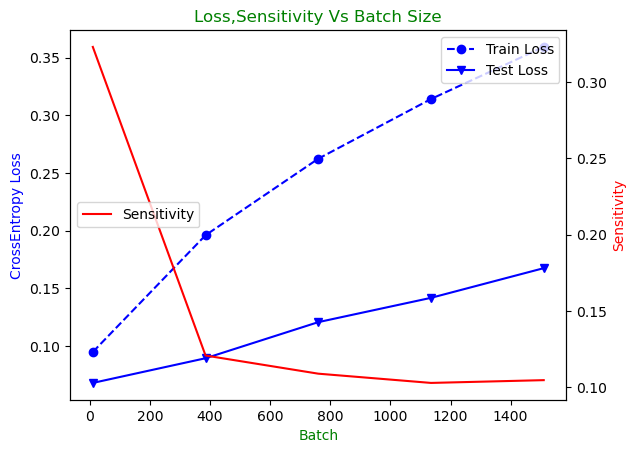

In [13]:
fig,ax=plt.subplots()
ax.plot(batchArr,minScore(modelsTrainLossArr),color="Blue", marker="o",linestyle='dashed')
ax.plot(batchArr,modelsTestLossArr,color="Blue", marker="v")
ax.legend(['Train Loss','Test Loss'],loc="upper right")
ax.set_xlabel("Batch",color="Green")
ax.set_ylabel("CrossEntropy Loss",color = "blue")
ax.set_title("Loss,Sensitivity Vs Batch Size",color="g")

ax2=ax.twinx()
ax2.plot(batchArr,minScore(modelsSensitivityArr),color="red")
ax2.set_xlabel("Batch",color="Green")
ax2.set_ylabel("Sensitivity",color = "red")
ax2.legend(['Sensitivity'],loc="center left")

plt.show()


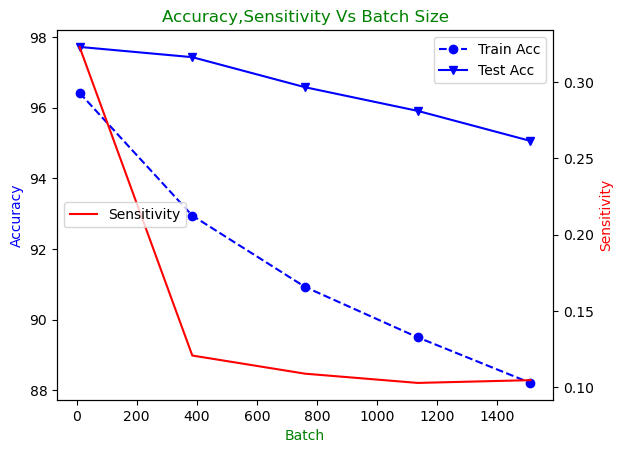

In [14]:
fig,ax=plt.subplots()
ax.plot(batchArr,minScore(modelsTrainAccArr),color="Blue", marker="o",linestyle='dashed')
ax.plot(batchArr,modelsTestAccArr,color="Blue", marker="v")
ax.legend(['Train Acc','Test Acc'],loc="upper right")
ax.set_xlabel("Batch",color="Green")
#ax.set_xscale('log')
ax.set_ylabel("Accuracy",color = "blue")
ax.set_title("Accuracy,Sensitivity Vs Batch Size",color="g")

ax2=ax.twinx()
ax2.plot(batchArr,minScore(modelsSensitivityArr),color="red")
ax2.set_xlabel("Batch",color="Green")
ax2.set_ylabel("Sensitivity",color = "red")
ax2.legend(['Sensitivity'],loc="center left")

plt.show()
